<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Upload Dataset**

## 1.1. Download and extract INbreast dataset

In [1]:
!pip install -q gdown

In [2]:
import zipfile
import gdown
import os

# Define file ID and output paths
file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

# Download zip from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet = False)

# Extract the zip file
with zipfile.ZipFile(zip_output, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=6aa3da05-e93e-4e4b-9961-c0f1abdef694
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [00:44<00:00, 44.8MB/s]


In [3]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

## 1.2 Convert DICOM to JPG

In [4]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 82.2 MB/s eta 0:00:00


In [5]:
import pydicom
import cv2
import numpy as np
import os
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok = True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)


for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

100%|██████████| 412/412 [00:50<00:00,  8.17it/s]


## 1.3 Convert ROI XML to JSON

In [6]:
import xml.etree.ElementTree as ET
import os
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    # Get all point strings inside the <array>
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"[INFO] ROI annotations parsed: {len(annotations)} images.")

[INFO] ROI annotations parsed: 343 images.


# **2. Preprocessing & Augmentation**

In [8]:
import os

base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    if dirs:
        print(f"   >Subdirectories: {dirs}")

    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['PectoralMuscle', 'AllROI', 'AllDICOMs', 'MedicalReports', 'AllXML']
    - README.txt
    - INbreast.xls
    - inbreast.pdf
    - INbreast.csv

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle
   >Subdirectories: ['Pectoral Muscle ROI', 'Pectoral Muscle XML']

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle ROI
    - 50996083_muscle.roi
    - 22678833_muscle.roi
    - 53582764_muscle.roi
    - 24055149_muscle.roi
    - 24065380_muscle.roi

 /content/INbreast_Extracted/INbreast Release 1.0/PectoralMuscle/Pectoral Muscle XML
    - 50998177_muscle.xml
    - 53581124_muscle.xml
    - 53587104_muscle.xml
    - 53580831_muscle.xml
    - 22613822_muscle.xml

 /content/INbreast_Extracted/INbreast Release 1.0/AllROI
    - 24065860.roi
    - 22614568.roi
    - 20587226.roi
    - 50993976.roi
    - 22670301.roi

 /content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs
    - 

## 2.1. Data Reading and Review

The INbreast dataset is provided in .csv format and is separated by a semicolon (;).

Therefore, when reading the dataset with pandas, the sep=";" parameter is given.

Otherwise, the columns are separated incorrectly and the data is loaded incorrectly.

In [10]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"
df = pd.read_csv(csv_path, sep=";")
df["filename"] = df["File Name"].astype(str) + ".jpg"

df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


## 2.2. BI-RADS Class Distribution

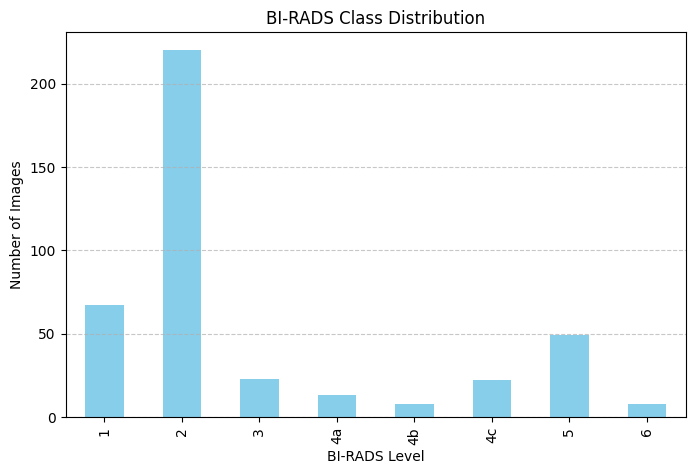

In [11]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize = (8, 5))
birads_counts.plot(kind = "bar", color = "skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
plt.show()

### 2.2.1. Sorting Images into Folders Based on BI-RADS Levels

* The .jpg files were copied into folders based on their classes using the df_clean DataFrame.

* Folder names were given as: "BI-RADS-1", "BI-RADS-2", "BI-RADS-3", "BI-RADS-4a", "BI-RADS-4b", "BI-RADS-4ac", "BI-RADS-5", "BI-RADS-6".

In [12]:
import shutil
from tqdm import tqdm

img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc = "Organizing images"):
    label = str(row["birads_label"]).strip()
    src = os.path.join(img_source_dir, row["filename"])
    dst_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, row["filename"])

    if os.path.exists(src):
        shutil.copy(src, dst)

Organizing images: 100%|██████████| 410/410 [00:00<00:00, 1119.89it/s]


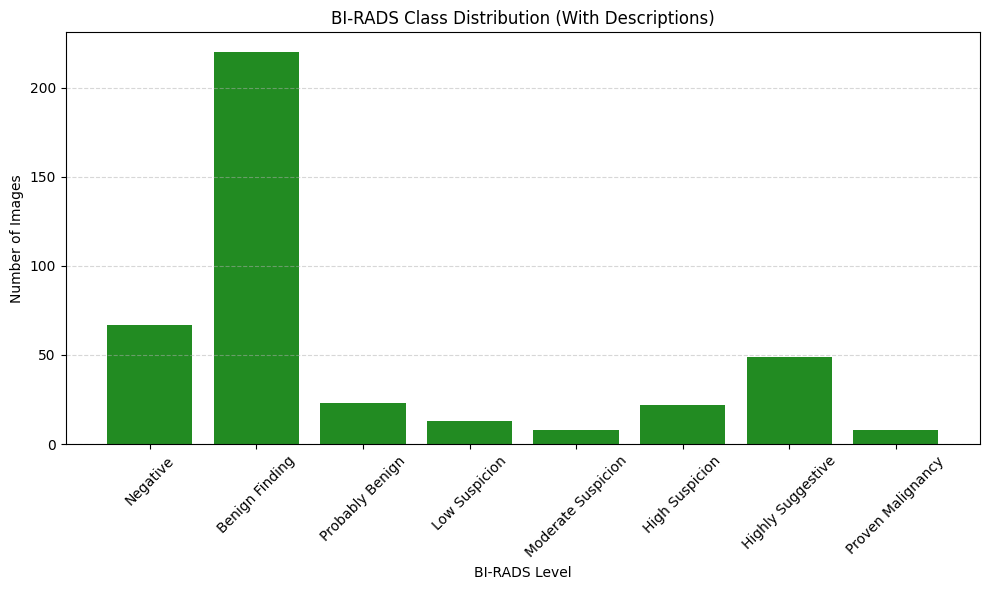

In [15]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

class_counts = {
    class_name: len([f for f in os.listdir(os.path.join(output_dir, class_name)) if f.endswith(".jpg")])
    for class_name in sorted(os.listdir(output_dir)) if class_name.startswith("BIRADS_")
}

sorted_labels = sorted(class_counts.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [class_counts[l] for l in sorted_labels],
    color = "forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.xticks(rotation = 45)
plt.grid(axis = 'y', linestyle = '--', alpha = 0.5)
plt.tight_layout()
plt.show()

## 2.3. Augmentation

Nested break statements were handled correctly.

The production count was controlled directly using a while loop.

Simplified using print instead of tqdm (can be added again if needed).

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

datagen = ImageDataGenerator(
    rotation_range = 2,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

target_count = 150
base_dir = output_dir  # /content/BI-RADS_split

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    to_generate = target_count - len(images)

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size = (224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for _ in datagen.flow(x, batch_size = 1,
                                  save_to_dir = class_path,
                                  save_prefix = "aug", save_format = "jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

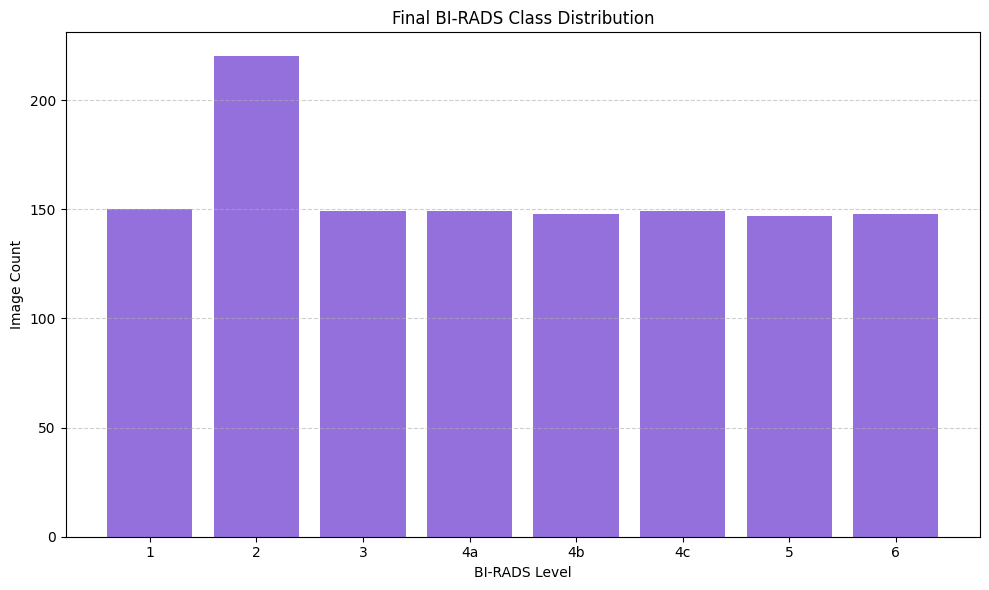

In [17]:
birads_counts_aug = {
    name: len([f for f in os.listdir(os.path.join(base_dir, name)) if f.endswith(".jpg")])
    for name in sorted(os.listdir(base_dir)) if name.startswith("BIRADS_")
}

x_labels = [extract_label(k) for k in birads_counts_aug.keys()]
y_counts = list(birads_counts_aug.values())

plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Final BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Image Count")
plt.grid(axis = "y", linestyle = "--", alpha = 0.6)
plt.tight_layout()
plt.show()

# **3. Dataset Splitting and Folder Structuring**

The entire dataset is divided into 80% train+val and 20% test and is permanently saved in the folder structure (as trainval and test). trainval can then be divided again into 80% train / 20% val by giving validation_split=0.2 with flow_from_directory().

In [18]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_dir = "/content/BI-RADS_split"
trainval_dir = "/content/BI-RADS_trainval_split"
test_dir = "/content/BI-RADS_test_split"

os.makedirs(trainval_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in sorted(os.listdir(original_dir)):
    class_path = os.path.join(original_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]

    # Skip if already split
    trainval_class_dir = os.path.join(trainval_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if os.path.exists(trainval_class_dir) and os.path.exists(test_class_dir):
        print(f"Skipping {class_name} (already split)")
        continue

    trainval_imgs, test_imgs = train_test_split(
        images, test_size=0.2, random_state=42
    )

    os.makedirs(trainval_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    for img in trainval_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(trainval_class_dir, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

    print(f"{class_name}: {len(trainval_imgs)} train/val, {len(test_imgs)} test")

BIRADS_1: 120 train/val, 30 test
BIRADS_2: 176 train/val, 44 test
BIRADS_3: 119 train/val, 30 test
BIRADS_4a: 119 train/val, 30 test
BIRADS_4b: 118 train/val, 30 test
BIRADS_4c: 119 train/val, 30 test
BIRADS_5: 117 train/val, 30 test
BIRADS_6: 118 train/val, 30 test


## 3.1. Data Generators (ImageDataGenerator & flow_from_directory)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainval_dir = "/content/BI-RADS_trainval_split"
test_dir = "/content/BI-RADS_test_split"

img_size = (224, 224)
batch_size = 32

# Train / Validation generators
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_gen = train_datagen.flow_from_directory(
    trainval_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True,
    seed = 42
)

val_gen = train_datagen.flow_from_directory(
    trainval_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = True,
    seed = 42
)

# Test generator (no augmentation or validation split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False
)

Found 809 images belonging to 8 classes.
Found 197 images belonging to 8 classes.
Found 254 images belonging to 8 classes.


# **4. Custom CNN Model**

In [22]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

In [23]:
# Class weight calculation
y_train_labels = train_gen.classes
class_weights_array = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train_labels),
    y = y_train_labels
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0533854166666667), 1: np.float64(0.7171985815602837), 2: np.float64(1.0533854166666667), 3: np.float64(1.0533854166666667), 4: np.float64(1.0644736842105262), 5: np.float64(1.0533854166666667), 6: np.float64(1.0757978723404256), 7: np.float64(1.0644736842105262)}


## 4.1. Custom CNN Architecture

In [25]:
input_shape = (224, 224, 3)

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.8),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model_cnn.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,464 (49.36 MB)

 Trainable params: 12,939,464 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 3,
    restore_best_weights = True
)

In [27]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model_cnn.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

## 4.2. Training

In [28]:
start_time = time.time()
history_cnn = model_cnn.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 50,
    callbacks = [early_stop, checkpoint],
    class_weight = class_weights,
    verbose = 1
)
end_time = time.time()
minutes, seconds = divmod(end_time - start_time, 60)
print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1533 - loss: 2.8166
Epoch 1: val_accuracy improved from -inf to 0.20812, saving model to best_model_cnn.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 27s 780ms/step - accuracy: 0.1538 - loss: 2.7992 - val_accuracy: 0.2081 - val_loss: 2.0343
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2657 - loss: 1.9115
Epoch 2: val_accuracy improved from 0.20812 to 0.23350, saving model to best_model_cnn.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 578ms/step - accuracy: 0.2653 - loss: 1.9100 - val_accuracy: 0.2335 - val_loss: 1.9881
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3738 - loss: 1.6366
Epoch 3: val_accuracy improved from 0.23350 to 0.28426, saving model to best_model_cnn.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 578ms/step - accuracy: 0.3733 - loss: 1.6363 - val_accuracy: 0.2843 - val_loss: 1.9285
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.4392 - loss: 1.4926
Epoch 4: val_accuracy impr

## 4.3. Evaluation

In [29]:
model_cnn.load_weights("best_model_cnn.keras")
loss, acc = model_cnn.evaluate(test_gen, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

254/254 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4492 - loss: 1.5466

 Test Accuracy: 0.5551 — Test Loss: 1.2918


## 4.4. Confusion Matrix

254/254 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


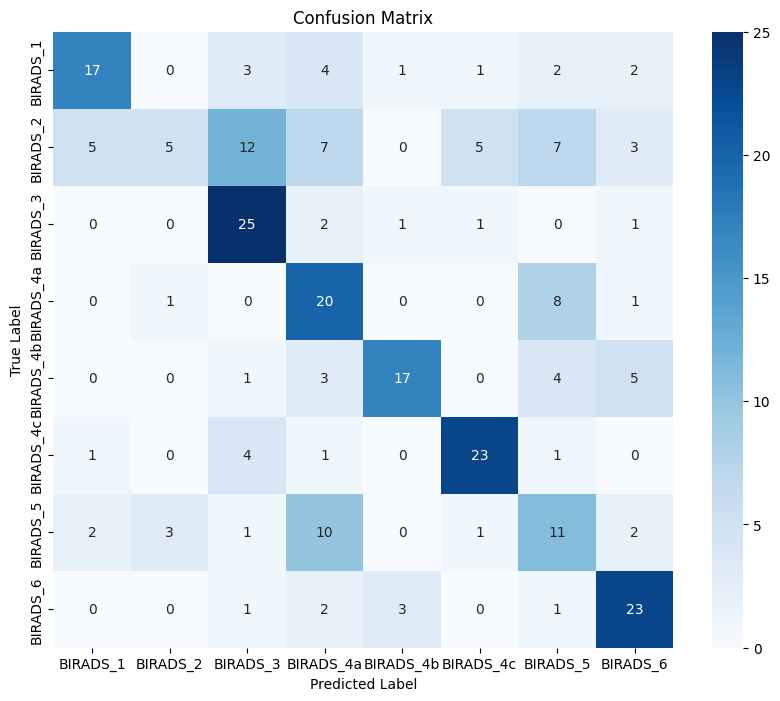

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ground truth and predictions
y_true = test_gen.classes
y_pred_probs = model_cnn.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis = 1)
class_names = list(test_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [31]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    BIRADS_1       0.68      0.57      0.62        30
    BIRADS_2       0.56      0.11      0.19        44
    BIRADS_3       0.53      0.83      0.65        30
   BIRADS_4a       0.41      0.67      0.51        30
   BIRADS_4b       0.77      0.57      0.65        30
   BIRADS_4c       0.74      0.77      0.75        30
    BIRADS_5       0.32      0.37      0.34        30
    BIRADS_6       0.62      0.77      0.69        30

    accuracy                           0.56       254
   macro avg       0.58      0.58      0.55       254
weighted avg       0.58      0.56      0.53       254



## 4.5. Accuracy & Loss Graphs

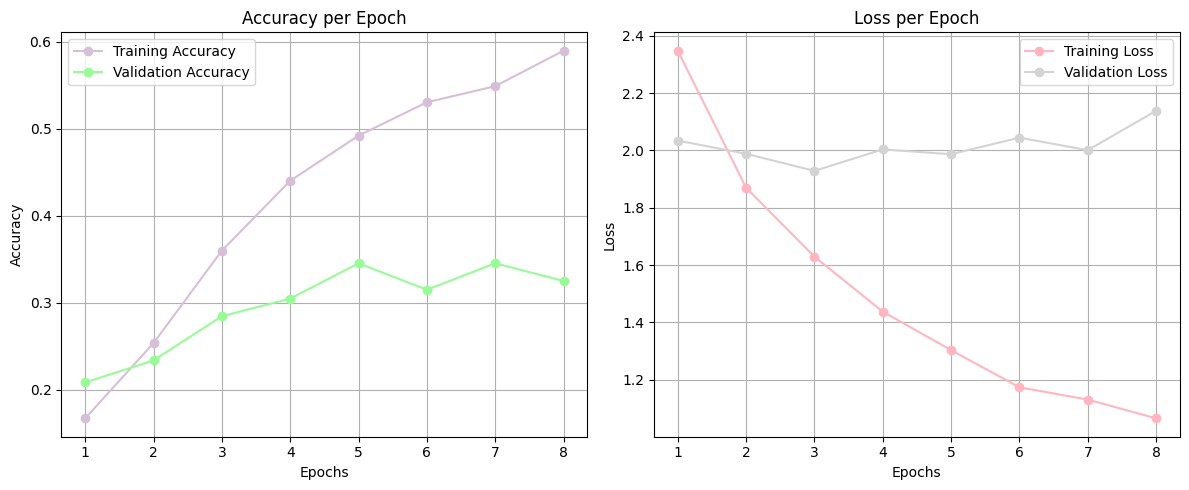

In [33]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker = 'o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4.6. ROI Visualization

In [46]:
pip install roifile

In [43]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
import numpy as np
import os
import random

from tensorflow.keras.preprocessing import image

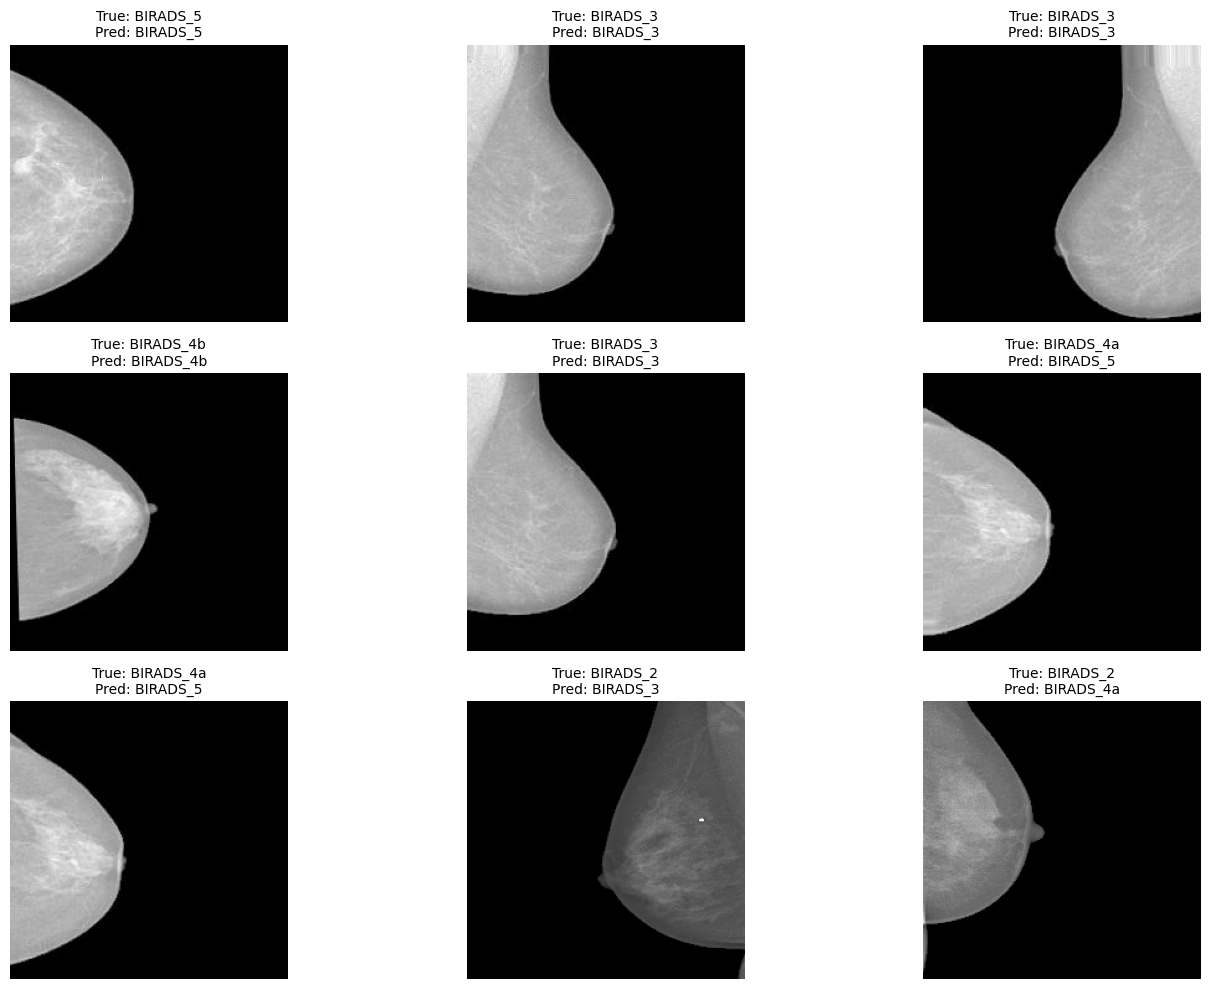

In [45]:
# Class labels from the generator
class_names = list(test_gen.class_indices.keys())

# Select 9 random indices from test data
indices = random.sample(range(len(test_gen.filenames)), 9)

plt.figure(figsize = (15, 10))

for i, idx in enumerate(indices):
    # Load and preprocess image
    img_path = os.path.join(test_gen.directory, test_gen.filenames[idx])
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    input_img = np.expand_dims(img_array, axis=0)

    # Prediction
    pred_idx = np.argmax(model_cnn.predict(input_img, verbose = 0))
    pred_label = class_names[pred_idx]

    # True label
    true_idx = test_gen.classes[idx]
    true_label = class_names[true_idx]

    # Plot image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

In [47]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Risk order of BI-RADS classes
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']

# Normalization (values between 0 and 1)
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}

# Color map: green to red (higher risk → more red)
cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red

# Get color based on class label
def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

# Determine color based on prediction correctness
def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"  # wrong prediction → black
    return get_color_from_birads(true_label)

# Generate color palette for each class
color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

<ipython-input-47-1962c5b44f26>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red


{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

# Function to calculate polygon area
def calculate_polygon_area(points):
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

# Draw ROI with approximate polygon area and color palette
def draw_roi_with_palette(img_path, image_id, annotations, true_label=None, pred_label=None, save_dir=None):
    from matplotlib.patches import Rectangle

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # ROI data
    rois = annotations.get(image_id, [])
    total_area = 0

    # Create figure and axes: 1x2 grid (left: image, right: color palette)
    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize = (12, 6), gridspec_kw = {'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(
            poly_coords,
            closed = True,
            edgecolor = color,
            facecolor = color,
            alpha = 0.3,
            linewidth = 2
        )
        ax_img.add_patch(polygon)

    # Title and display settings
    title = f"True: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\n"
    title += f"ROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize = 12)
    ax_img.axis("off")

    # Palette layout settings
    box_height = 0.6
    spacing = 0.15

    extra_items = 2  # Misestimation + Unknown
    total_items = len(birads_order) + extra_items
    full_height = total_items * (box_height + spacing)

    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    # Draw palette boxes
    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color=color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va = 'center', ha = 'left', fontsize = 10)

    # Misestimation box (black)
    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va = 'center', ha = 'left', fontsize = 10)

    # Unknown box (purple)
    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va = 'center', ha = 'left', fontsize = 10)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok = True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()

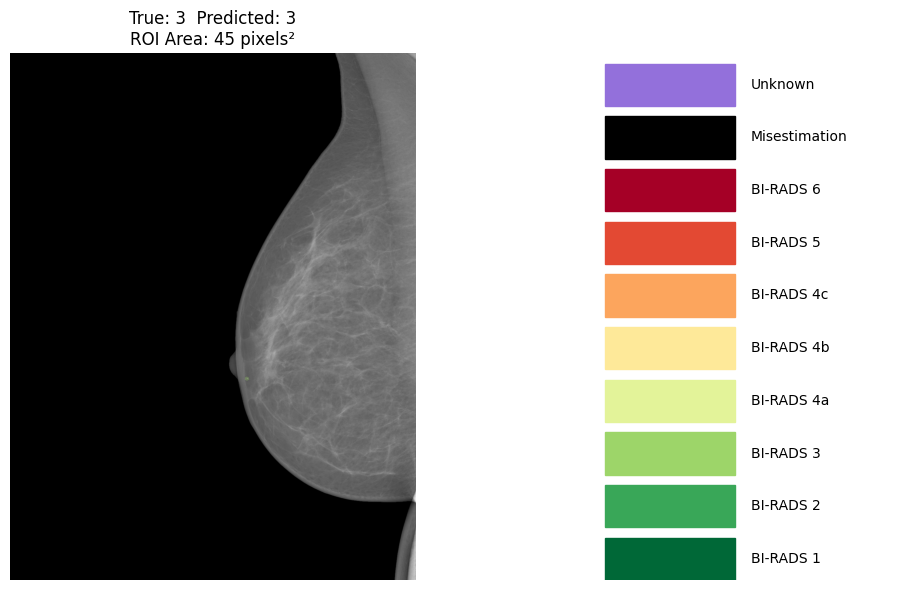

In [58]:
import random

# Filter images that contain ROIs with polygons having at least 3 points
valid_ids_with_polygon = [
    k for k, v in annotations.items()
    if any(len(roi["points"]) >= 3 for roi in v)
]

# Select a random sample
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Randomly assign true and predicted labels (for testing purposes)
true_label = random.choice(birads_order)
pred_label = random.choice(birads_order)

# Draw the enhanced ROI visualization with color palette
draw_roi_with_palette(
    img_path = img_path,
    image_id = sample_id,
    annotations = annotations,
    true_label = true_label,
    pred_label = pred_label,
    save_dir = None
)

# **5. DenseNet121**

In [59]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

## 5.1. Model Architecture

In [61]:
input_shape = (224, 224, 3)
num_classes = train_gen.num_classes

# Base model
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.trainable = True  # Fine-tuning allowed

# Custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Final model
model_densenet = Model(inputs = base_model.input, outputs = output)

model_densenet.compile(
    optimizer=Adam(learning_rate = 1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_densenet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,736 (27.35 MB)

 Trainable params: 7,086,088 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [62]:
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )

checkpoint = ModelCheckpoint(
    "best_model_densenet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

## 5.2. Training

In [63]:
start = time.time()

history_densenet = model_densenet.fit(
    train_gen,
    validation_data = val_gen,
    epochs = 50,
    callbacks = [early_stop, checkpoint],
    class_weight = class_weights,
    verbose = 1
)

end = time.time()
print(f"Training time: {int((end - start) // 60)} minutes {int((end - start) % 60)} seconds")

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4754 - loss: 1.5780
Epoch 1: val_accuracy improved from -inf to 0.15736, saving model to best_model_densenet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - accuracy: 0.4836 - loss: 1.5577 - val_accuracy: 0.1574 - val_loss: 2.1098
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9409 - loss: 0.2464
Epoch 2: val_accuracy improved from 0.15736 to 0.23350, saving model to best_model_densenet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step - accuracy: 0.9405 - loss: 0.2458 - val_accuracy: 0.2335 - val_loss: 2.0930
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9486 - loss: 0.1700
Epoch 3: val_accuracy improved from 0.23350 to 0.25381, saving model to best_model_densenet.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 615ms/step - accuracy: 0.9490 - loss: 0.1688 - val_accuracy: 0.2538 - val_loss: 2.1418
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9759 - loss: 0.0952
Epoch 4: val_acc

## 5.3. Evaluation

In [64]:
from tensorflow.keras.models import load_model

model = load_model("best_model_densenet.keras")

loss, acc = model.evaluate(test_gen, verbose = 1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.7335 - loss: 1.2400

Test Accuracy: 0.8543 — Test Loss: 0.7378


### 5.4. Confusion Matrix

In [65]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels
y_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen.classes

# Class labels
class_names = list(test_gen.class_indices.keys())

254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step


In [66]:
# Report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    BIRADS_1       0.81      0.57      0.67        30
    BIRADS_2       0.56      0.93      0.70        44
    BIRADS_3       1.00      0.80      0.89        30
   BIRADS_4a       1.00      1.00      1.00        30
   BIRADS_4b       1.00      0.97      0.98        30
   BIRADS_4c       1.00      0.83      0.91        30
    BIRADS_5       0.96      0.77      0.85        30
    BIRADS_6       1.00      0.93      0.97        30

    accuracy                           0.85       254
   macro avg       0.92      0.85      0.87       254
weighted avg       0.90      0.85      0.86       254



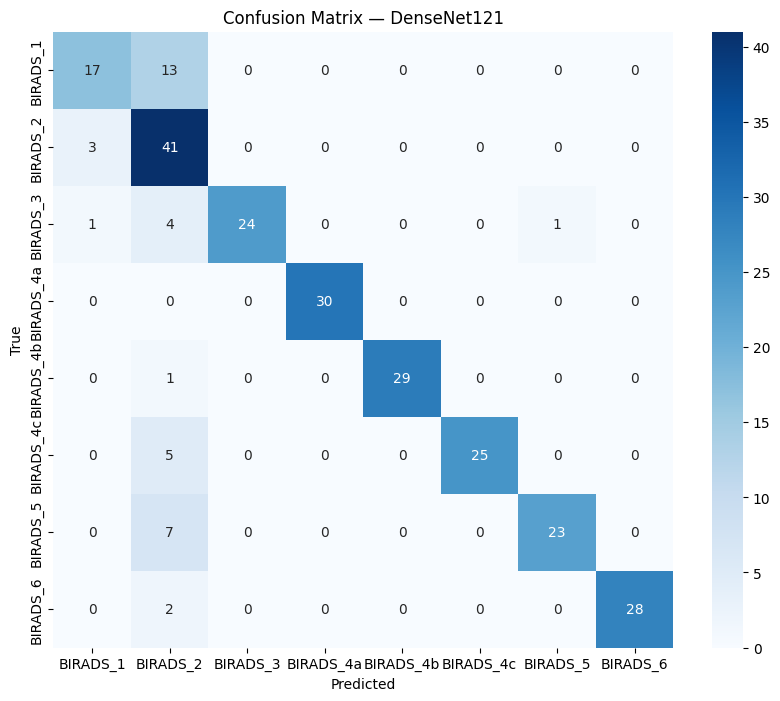

In [67]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — DenseNet121")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 5.4. Accuracy & Loss Graphs

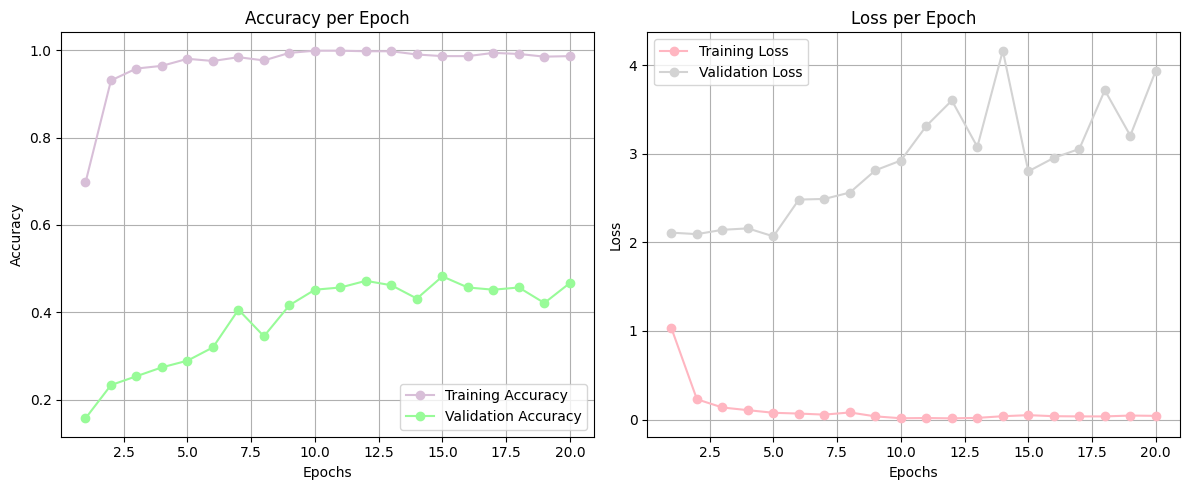

In [68]:
import matplotlib.pyplot as plt

acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))

# Load base model
base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.trainable = False

# Custom classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.6)(x)
output = Dense(num_classes, activation = 'softmax')(x)

# Build model
model_vgg = Model(inputs = base_model.input, outputs = output)

# Compile
model_vgg.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model_vgg.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Class Weight Calculation
from sklearn.utils.class_weight import compute_class_weight

class_weights_raw = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)
class_weights = dict(enumerate(class_weights_raw))

## 7.2. Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

checkpoint = ModelCheckpoint(
    "best_model_vgg16.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

In [ ]:
import time
start = time.time()

history_vgg = model_vgg.fit(
    X_train, y_train_cat,
    validation_data = (X_test, y_test_cat),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    class_weight = class_weights,
    verbose = 1
)

end = time.time()
print(f"Training time: {int((end - start) // 60)} minutes {int((end - start) % 60)} seconds")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.1436 - loss: 2.4235
Epoch 1: val_accuracy improved from -inf to 0.11811, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.1432 - loss: 2.4217 - val_accuracy: 0.1181 - val_loss: 2.0855
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.1259 - loss: 2.1643
Epoch 2: val_accuracy improved from 0.11811 to 0.16929, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.1259 - loss: 2.1653 - val_accuracy: 0.1693 - val_loss: 2.0479
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1451 - loss: 2.1812
Epoch 3: val_accuracy improved from 0.16929 to 0.28740, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.1454 - loss: 2.1807 - val_accuracy: 0.2874 - val_loss: 2.0269
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.1428 - loss: 2.1550
Epoch 4: val_accuracy 

## 7.3. Evaluation

In [ ]:
from tensorflow.keras.models import load_model

best_model_vgg = load_model("best_model_vgg16.keras")
loss, acc = model_vgg.evaluate(X_test, y_test_cat, verbose=1)
print(f"\n Test Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6607 - loss: 1.9042

 Test Accuracy: 0.6614 — Test Loss: 1.9021


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step
              precision    recall  f1-score   support

           1       0.80      0.67      0.73        30
           2       0.55      0.14      0.22        44
           3       0.62      0.93      0.75        30
          4a       0.93      0.43      0.59        30
          4b       0.65      1.00      0.79        30
          4c       0.89      0.83      0.86        30
           5       0.57      0.57      0.57        30
           6       0.53      0.97      0.68        30

    accuracy                           0.66       254
   macro avg       0.69      0.69      0.65       254
weighted avg       0.68      0.66      0.62       254



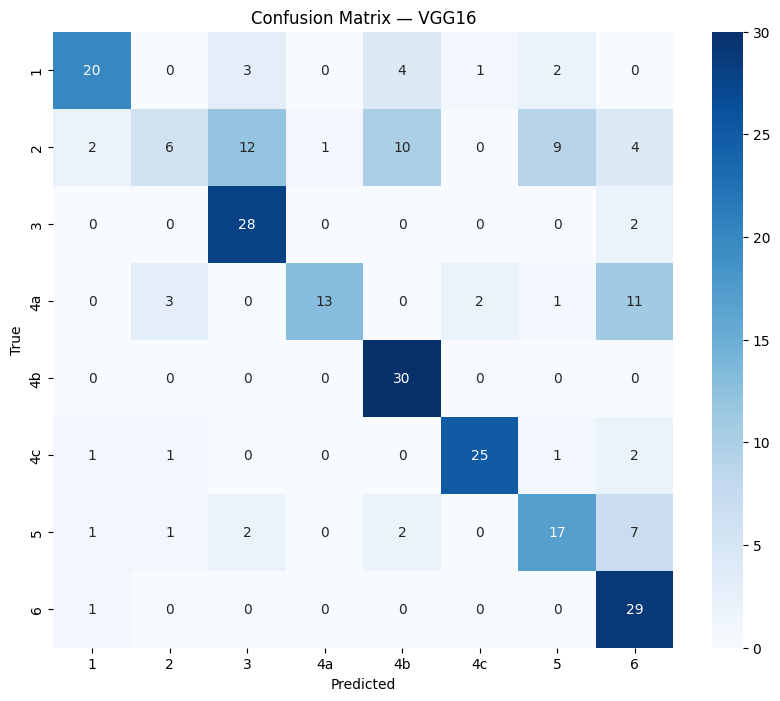

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict
y_pred_probs = best_model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = le.classes_

# Report
print(classification_report(y_test, y_pred, target_names = class_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.title("Confusion Matrix — VGG16")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

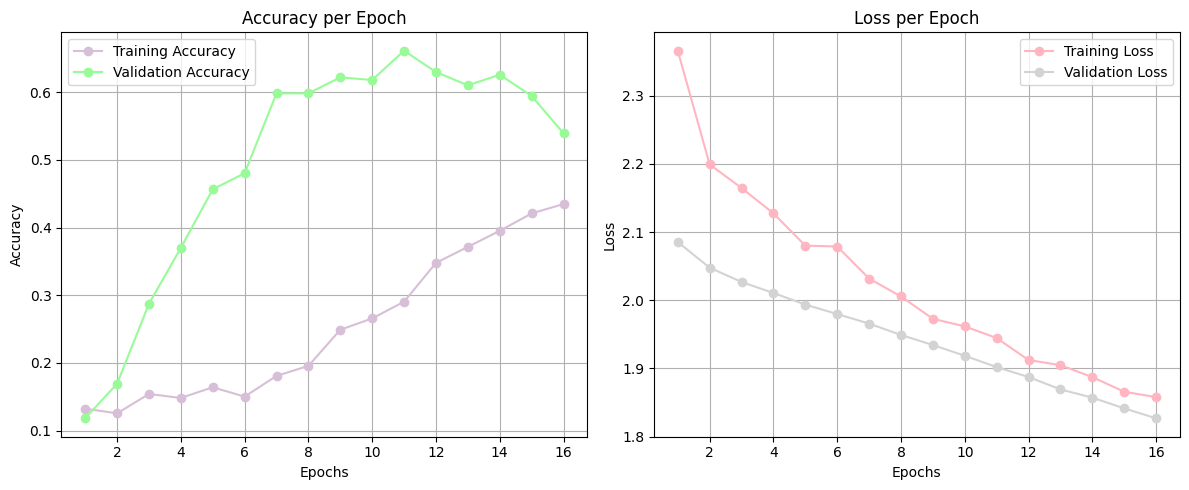

In [ ]:
import matplotlib.pyplot as plt

acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color = 'thistle', marker = 'o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, color = 'palegreen', marker = 'o', label = 'Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color = 'lightpink', marker='o', label = 'Training Loss')
plt.plot(epochs, val_loss, color = 'lightgray', marker = 'o', label = 'Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. EfficientNetB0**

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

## 8.1. Feature Extraction

In [ ]:
input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))

In [ ]:
# EfficientNetB0 + spacial layers
base_model = EfficientNetB0(include_top = False, weights = 'imagenet', input_shape = input_shape)
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.6)(x)
output = Dense(num_classes, activation = 'softmax')(x)

model_efficient = Model(inputs = base_model.input, outputs = output)

In [ ]:
model_efficient.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
    )
checkpoint = ModelCheckpoint(
    "best_model_efficientnet.keras",
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
    )

## 8.2. Training

In [ ]:
# Training
start = time.time()

history_efficient = model_efficient.fit(
    X_train, y_train_cat,
    shuffle=True,
    validation_data = (X_test, y_test_cat),
    epochs = 50,
    batch_size = 32,
    callbacks = [early_stop, checkpoint],
    class_weight = class_weights,
    verbose = 1
)

end = time.time()
print(f"Training time: {int((end-start)//60)} minutes {int((end-start)%60)} seconds")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.1330 - loss: 2.1808
Epoch 1: val_accuracy improved from -inf to 0.17323, saving model to best_model_efficientnet.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.1339 - loss: 2.1794 - val_accuracy: 0.1732 - val_loss: 2.0860
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2355 - loss: 1.9850
Epoch 2: val_accuracy did not improve from 0.17323
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.2359 - loss: 1.9852 - val_accuracy: 0.1181 - val_loss: 2.0892
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2746 - loss: 1.9576
Epoch 3: val_accuracy did not improve from 0.17323
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.2751 - loss: 1.9562 - val_accuracy: 0.1181 - val_loss: 2.1066
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3683 - loss: 1.8137
Epoch 4: val_accuracy did not improve from 0.17323
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0

## 8.3. Confusion Matrix & Classification Report

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
model = load_model("best_model_efficientnet.keras")

loss, acc = model_efficient.evaluate(X_test, y_test_cat, verbose=1)
print(f"\nTest Accuracy: {acc:.4f} — Test Loss: {loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1867 - loss: 2.0789

Test Accuracy: 0.1732 — Test Loss: 2.0860


In [ ]:
# Prediction
y_pred_probs = model_efficient.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
class_names = le.classes_

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 789ms/step


In [ ]:
# Classification Report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        30
           2       0.17      1.00      0.30        44
           3       0.00      0.00      0.00        30
          4a       0.00      0.00      0.00        30
          4b       0.00      0.00      0.00        30
          4c       0.00      0.00      0.00        30
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        30

    accuracy                           0.17       254
   macro avg       0.02      0.12      0.04       254
weighted avg       0.03      0.17      0.05       254



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


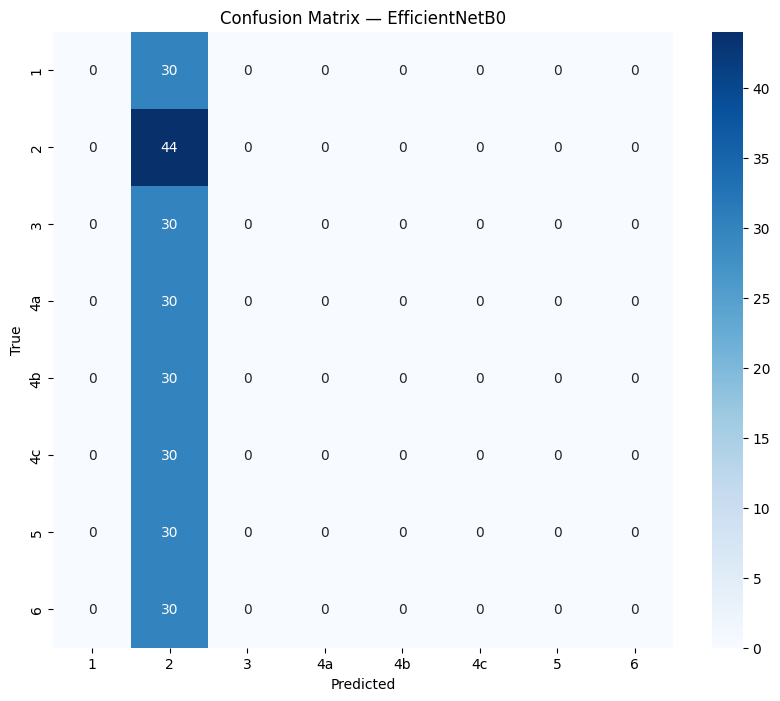

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — EfficientNetB0')
plt.show()

In [ ]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Class {label}: {count} samples")

Class 0: 120 samples
Class 1: 176 samples
Class 2: 120 samples
Class 3: 120 samples
Class 4: 120 samples
Class 5: 118 samples
Class 6: 120 samples
Class 7: 118 samples


In [ ]:
print("y_train shape:", y_train.shape)
print("y_train_cat shape:", y_train_cat.shape)

y_train shape: (1012,)
y_train_cat shape: (1012, 8)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("X_train min/max:", X_train.min(), "/", X_train.max())

X_train shape: (1012, 224, 224, 3)
X_train dtype: float32
X_train min/max: 0.0 / 1.0


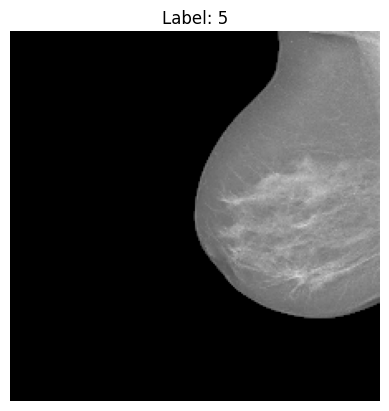

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0])
plt.title(f"Label: {y_train[0]}")
plt.axis("off")
plt.show()

In [ ]:
print(np.unique(y_train, return_counts=True))


(array([0, 1, 2, 3, 4, 5, 6, 7]), array([120, 176, 120, 120, 120, 118, 120, 118]))
